# Self-Attention Analysis

In [18]:
import sys

#@markdown Execute this cell to import third-party software into the Colab environment.

# check whether it runs in Colab
root = "."
if "google.colab" in sys.modules:
    print("Running in Colab.")
    !pip3 install timm==0.5.4
    !pip3 install matplotlib==3.7.1
    !pip3 install scikit-learn==1.2.2
    !pip3 install fastai==2.7.12
    !pip3 install einops==0.6.0
    !pip3 install gdown==4.7.1
    !pip3 install yacs==0.1.8    
    !git clone https://github.com/naver-ai/cl-vs-mim.git
    root = "./cl-vs-mim"
    %cd $root

In [19]:
import torch

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 2.7.1+cu118 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x0000027604D867A0> 
Device name: NVIDIA GeForce RTX 2070


In [20]:
import os
import math
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Configuration
DATASET = "flowers102"  # @param ["cifar100", "flowers102"]
METHOD = "pretrained"       # @param ["full", "lora", "bitfit", "adaptformer"]

# Dataset configurations
dataset_configs = {
    "cifar100": {
        "num_classes": 100,
        "data_dir": "./data/cifar-100-python",
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225]
    },
    "flowers102": {
        "num_classes": 102,
        "data_dir": "./data/flowers102/dataset",
        "mean": [0.485, 0.456, 0.406], 
        "std": [0.229, 0.224, 0.225]
    }
}

config = dataset_configs[DATASET]

# Transform for analysis
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(config["mean"], config["std"])
])

# Load dataset with proper error handling
if DATASET == "cifar100":
    dataset_full = datasets.CIFAR100(
        root=config["data_dir"], 
        train=False, 
        download=True, 
        transform=transform_test
    )
    print(f"CIFAR-100 loaded: {len(dataset_full)} images")
elif DATASET == "flowers102":
    test_dir = os.path.join(config["data_dir"], "valid")
    if not os.path.exists(test_dir):
        print(f"Directory not found: {test_dir}")
        # Try alternative paths
        alt_paths = ["./data/flowers102/dataset/valid", "./data/flowers102/valid"]
        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                test_dir = alt_path
                break
    
    dataset_full = datasets.ImageFolder(test_dir, transform=transform_test)
    print(f"Flowers102 loaded: {len(dataset_full)} images from {test_dir}")

# Better subsampling - use manual selection to ensure we get samples
original_size = len(dataset_full)

# For attention analysis, take every 8th sample (gives us ~128 samples from 1020)
if original_size > 200:
    step_size = max(1, original_size // 100)  # Aim for ~100 samples
    indices = list(range(0, original_size, step_size))
else:
    indices = list(range(original_size))  # Use all if small dataset

dataset_subset = Subset(dataset_full, indices)
print(f"Subsampled to {len(dataset_subset)} images (every {step_size if original_size > 200 else 1} samples)")

# Create DataLoader with reasonable batch size
dataset_test = DataLoader(dataset_subset, num_workers=0, batch_size=16, shuffle=False)

# Test the DataLoader
try:
    test_batch = next(iter(dataset_test))
    print(f"DataLoader working - batch shape: {test_batch[0].shape}")
    # Reset the iterator
    dataset_test = DataLoader(dataset_subset, num_workers=0, batch_size=16, shuffle=False)
except Exception as e:
    print(f"DataLoader error: {e}")

print(f"Final dataset status: Ready with {len(dataset_subset)} samples")

Flowers102 loaded: 1020 images from ./data/flowers102/dataset\valid
Subsampled to 102 images (every 10 samples)
DataLoader working - batch shape: torch.Size([16, 3, 224, 224])
Final dataset status: Ready with 102 samples


## Load the Models

In [ ]:
import torch
from transformers import ViTForImageClassification
from models.lora_vit import apply_lora_to_vit
from models.adapt_former import apply_adaptformer_to_vit
from models.bitfit_vit import apply_bitfit_to_vit

def load_finetuned_model(checkpoint_path, dataset_name, method="full"):
    """Load a fine-tuned model from checkpoint with full method support"""
    
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
    
    num_classes_map = {"cifar100": 100, "flowers102": 102}
    num_classes = num_classes_map[dataset_name]
    
    try:
        # Create base model
        model = ViTForImageClassification.from_pretrained(
            "facebook/dino-vits16",
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
            output_attentions=True,
            output_hidden_states=True
        )
        
        # Apply method-specific modifications BEFORE loading weights
        if method == "lora":
            apply_lora_to_vit(model, r=8, alpha=16, dropout=0.1)
            print(f"Applied LoRA modifications")
        elif method == "adaptformer":
            apply_adaptformer_to_vit(model, bottleneck_dim=64)
            print(f"Applied AdaptFormer modifications")
        elif method == "bitfit":
            # BitFit modifications happen after loading
            print(f"BitFit will be applied after loading")
        
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Apply BitFit after loading (it only changes requires_grad flags)
        if method == "bitfit":
            apply_bitfit_to_vit(model, verbose=False)
        
        model = model.cuda().eval()
        print(f"Loaded: {dataset_name}_{method}")
        return model
        
    except Exception as e:
        print(f"Error loading {checkpoint_path}: {e}")
        return None

def load_pretrained_dino(dataset_name):
    """Load the original pre-trained DINO model for comparison"""
    try:
        # Get number of classes for the dataset
        num_classes_map = {"cifar100": 100, "flowers102": 102}
        num_classes = num_classes_map[dataset_name]
        
        # Load pre-trained DINO model
        model = ViTForImageClassification.from_pretrained(
            "facebook/dino-vits16",
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
            output_attentions=True,
            output_hidden_states=True
        )
        
        model = model.cuda().eval()
        print(f"Loaded pre-trained DINO for {dataset_name}")
        return model
        
    except Exception as e:
        print(f"Error loading pre-trained DINO: {e}")
        return None

def create_analysis_wrapper(model):
    """Wrap the model to match expected interface for attention analysis"""
    def wrapped_forward(x):
        with torch.no_grad():
            outputs = model(pixel_values=x, output_attentions=True, output_hidden_states=True)
        
        logits = outputs.logits
        hidden_states = outputs.hidden_states
        attentions = outputs.attentions
        
        # Format for analysis (mimic original interface)
        zs = list(hidden_states) if hidden_states else []
        attns = list(attentions) if attentions else [None] * len(zs)
        attn_fts = [None] * len(zs)
        
        return logits, zs, attns, attn_fts
    
    model.forward_analysis = wrapped_forward
    return model

# Test loading all models
print("Testing model loading...")
models = {}
methods = ["full", "lora", "bitfit", "adaptformer"]
datasets = ["cifar100", "flowers102"]

for dataset in datasets:
    for method in methods:
        checkpoint_path = f"./checkpoints/{dataset}/{method}/best_checkpoint_{dataset}_{method}.pth"
        model_key = f"{dataset}_{method}"
        models[model_key] = load_finetuned_model(checkpoint_path, dataset, method)
    
    # Add pre-trained DINO for each dataset
    print(f"Loading pre-trained DINO for {dataset}...")
    pretrained_dino = load_pretrained_dino(dataset)
    if pretrained_dino is not None:
        dino_key = f"{dataset}_pretrained"
        models[dino_key] = pretrained_dino
        print(f"Added pre-trained DINO: {dino_key}")

# Filter and wrap successful models
available_models = {}
for k, v in models.items():
    if v is not None:
        available_models[k] = create_analysis_wrapper(v)

print(f"\nAvailable models: {list(available_models.keys())}")

# Select model for analysis - Updated to handle pretrained
if METHOD == "pretrained":
    current_model_key = f"{DATASET}_pretrained"
else:
    current_model_key = f"{DATASET}_{METHOD}"

if current_model_key in available_models:
    selected_model = available_models[current_model_key]
    print(f"Selected for analysis: {current_model_key}")
else:
    print(f"Selected model {current_model_key} not available")
    if available_models:
        fallback_key = list(available_models.keys())[0]
        selected_model = available_models[fallback_key]
        print(f"Using fallback: {fallback_key}")
    else:
        selected_model = None
        print("No models available for analysis")

🔍 Testing model loading...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded: cifar100_full


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model structure before LoRA:
Module: vit
Module: vit.embeddings
Module: vit.embeddings.patch_embeddings
Module: vit.encoder
Module: vit.encoder.layer
Linear layer: classifier -> in:384, out:100
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Ap

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit will be applied after loading
✅ Loaded: cifar100_bitfit


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AdaptFormer applied
Applied AdaptFormer modifications
✅ Loaded: cifar100_adaptformer
🔍 Loading pre-trained DINO for cifar100...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded pre-trained DINO for cifar100
📋 Added pre-trained DINO: cifar100_pretrained


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded: flowers102_full


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model structure before LoRA:
Module: vit
Module: vit.embeddings
Module: vit.embeddings.patch_embeddings
Module: vit.encoder
Module: vit.encoder.layer
Linear layer: classifier -> in:384, out:102
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Ap

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BitFit will be applied after loading
✅ Loaded: flowers102_bitfit


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AdaptFormer applied
Applied AdaptFormer modifications
✅ Loaded: flowers102_adaptformer
🔍 Loading pre-trained DINO for flowers102...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded pre-trained DINO for flowers102
📋 Added pre-trained DINO: flowers102_pretrained

📋 Available models: ['cifar100_full', 'cifar100_lora', 'cifar100_bitfit', 'cifar100_adaptformer', 'cifar100_pretrained', 'flowers102_full', 'flowers102_lora', 'flowers102_bitfit', 'flowers102_adaptformer', 'flowers102_pretrained']
🎯 Selected for analysis: flowers102_pretrained


## Attention Map Visualization

Running Attention Visualization for flowers102_pretrained...
Got batch - xs: torch.Size([16, 3, 224, 224]), ys: 16
Wrapper attention layers: 12
Non-None layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Using layer 11 for visualization
Using batch index: 0


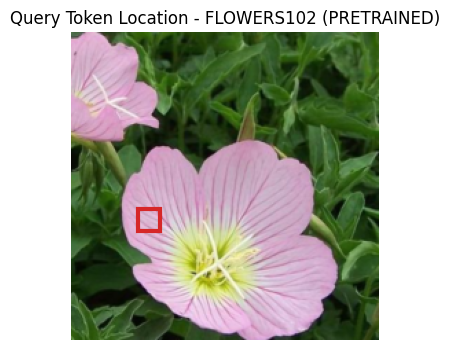

Batch attention shape: torch.Size([6, 197, 197])
Head attention shape: torch.Size([197, 197])
After CLS removal: torch.Size([196, 196])
Sequence length (sqrt): 14
Query index: 115 (i=3, j=8)
Final attention map shape: torch.Size([14, 14])


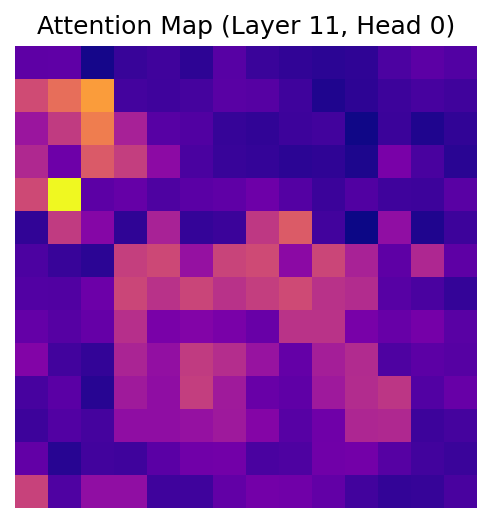

In [22]:
# Cell: Attention Map Visualization - Enhanced Error Handling
import matplotlib.pyplot as plt

def mark_token(ax, xs, batch, i, j, color='tab:red'):
    import matplotlib.patches as patches
    from einops import rearrange
    
    # Denormalize for visualization - ensure all tensors are on the same device
    device = xs.device
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    xs_denorm = xs * std + mean
    xs_denorm = torch.clamp(xs_denorm, 0, 1)
    
    # Move to CPU for visualization
    xs_denorm_cpu = xs_denorm.cpu()
    
    ax.imshow(rearrange(xs_denorm_cpu[batch], 'c h w -> h w c'))
    ax.set_axis_off()

    # Create rectangle patch to visualize the query token
    rect = patches.Rectangle((16 * i, 16 * j), 16, 16, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_attn(ax, attns, batch, i, j, depth, head):
    """Visualize attention maps for fine-tuned models"""
        
    if depth >= len(attns) or attns[depth] is None:
        ax.text(0.5, 0.5, f"No attention data at layer {depth}", ha='center', va='center', transform=ax.transAxes)
        print(f"   - Available layers: {[i for i, a in enumerate(attns) if a is not None]}")
        return
    
    attn = attns[depth]
    
    if batch >= attn.shape[0]:
        ax.text(0.5, 0.5, f"Batch {batch} out of range (max: {attn.shape[0]-1})", ha='center', va='center', transform=ax.transAxes)
        return
    
    attn_batch = attn[batch]  # Get attention for specific batch
    print(f"Batch attention shape: {attn_batch.shape}")
    
    if attn_batch.dim() == 3:  # (num_heads, seq_len, seq_len)
        if head >= attn_batch.shape[0]:
            ax.text(0.5, 0.5, f"Head {head} out of range (max: {attn_batch.shape[0]-1})", ha='center', va='center', transform=ax.transAxes)
            return
        attn_head = attn_batch[head]  # Select specific head
        print(f"Head attention shape: {attn_head.shape}")
    elif attn_batch.dim() == 2:  # Already (seq_len, seq_len)
        attn_head = attn_batch
        print(f"Using 2D attention directly: {attn_head.shape}")
    else:
        ax.text(0.5, 0.5, f"Unexpected attention shape: {attn_batch.shape}", ha='center', va='center', transform=ax.transAxes)
        return
    
    # Remove CLS token
    attn_no_cls = attn_head[1:, 1:]  
    print(f"After CLS removal: {attn_no_cls.shape}")
    
    # Normalize
    attn_norm = attn_no_cls / attn_no_cls.sum(dim=-1, keepdim=True)
    
    # Get attention for specific query token
    seq_len = int(math.sqrt(attn_norm.shape[0]))
    print(f"Sequence length (sqrt): {seq_len}")
    
    if seq_len * seq_len != attn_norm.shape[0]:
        ax.text(0.5, 0.5, f"Non-square attention: {attn_norm.shape[0]} != {seq_len}²", ha='center', va='center', transform=ax.transAxes)
        return
    
    query_idx = j * seq_len + i
    print(f"Query index: {query_idx} (i={i}, j={j})")
    
    if query_idx >= attn_norm.shape[0]:
        ax.text(0.5, 0.5, f"Query {query_idx} out of range (max: {attn_norm.shape[0]-1})", ha='center', va='center', transform=ax.transAxes)
        return
        
    attn_map = attn_norm[query_idx].reshape(seq_len, seq_len)
    print(f"Final attention map shape: {attn_map.shape}")
    
    ax.imshow(attn_map.cpu().numpy(), cmap="plasma")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()

# Run attention visualization with better error handling
if selected_model is not None:
    print(f"Running Attention Visualization for {DATASET}_{METHOD}...")
    
    # Check if dataset has any data first
    try:
        xs, ys = next(iter(dataset_test))
        print(f"Got batch - xs: {xs.shape}, ys: {len(ys)}")
    except StopIteration:
        print("Dataset is empty - no data available for visualization")
        print("Please run the dataset loading cell again with proper subsampling")
    except Exception as e:
        print(f"Error getting data: {e}")
    else:
        # Parameters for visualization
        depth = min(10, 11)  # Layer depth (0-11 for ViT-Base)
        batch = 0            # Use first batch to avoid issues
        coord_x = 3          # Query token x coordinate
        coord_y = 8          # Query token y coordinate  
        head = 0             # Attention head
        
        with torch.no_grad():
            xs = xs.cuda()                      
            
            _, _, attns, _ = selected_model.forward_analysis(xs)
            print(f"Wrapper attention layers: {len(attns)}")
            print(f"Non-None layers: {[i for i, a in enumerate(attns) if a is not None]}")
        
        # Adjust parameters based on actual data
        if len(attns) > 0:
            # Find a valid layer with attention data
            valid_layers = [i for i, a in enumerate(attns) if a is not None]
            if valid_layers:
                depth = valid_layers[-1]  # Use the last valid layer
                print(f"Using layer {depth} for visualization")
            else:
                print("No valid attention layers found")
                depth = None
        
        # Adjust batch size
        batch = min(batch, xs.shape[0] - 1)
        print(f"Using batch index: {batch}")
        
        # Visualize original image with query token marked
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
        mark_token(ax, xs, batch=batch, i=coord_x, j=coord_y, color='tab:red')
        ax.set_title(f"Query Token Location - {DATASET.upper()} ({METHOD.upper()})")
        plt.show()
        
        # Visualize attention map
        if depth is not None:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
            visualize_attn(ax, attns, batch=batch, i=coord_x, j=coord_y, depth=depth, head=head)
            ax.set_title(f"Attention Map (Layer {depth}, Head {head})")
            plt.show()
        else:
            print("Cannot visualize attention - no valid layers")
    
else:
    print("No model available for attention visualization")

## Attention Distance

Running Attention Distance Analysis for flowers102_pretrained...


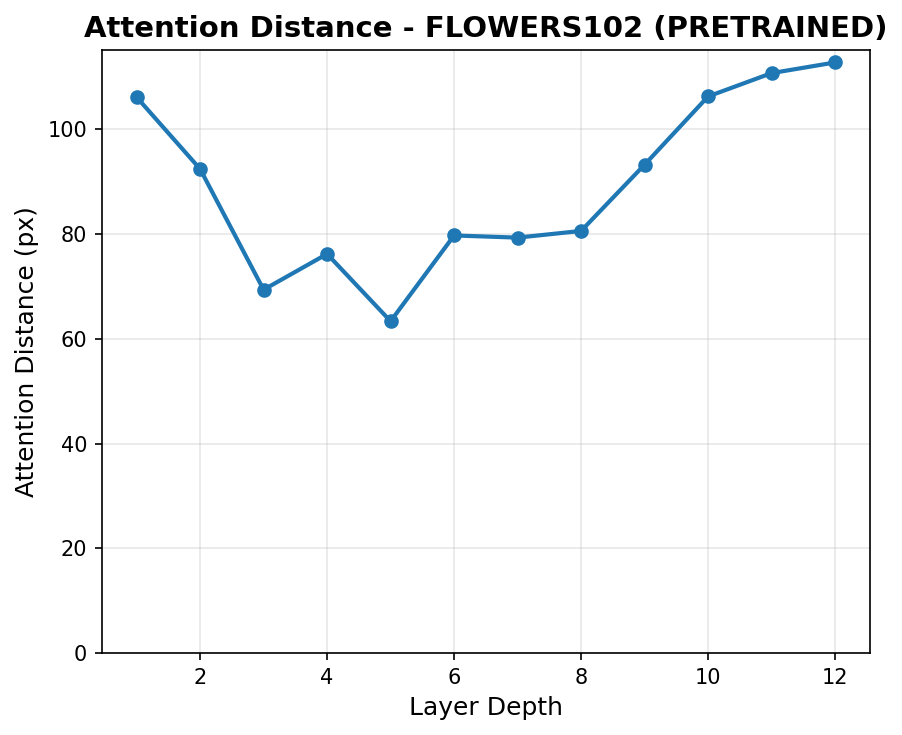

In [23]:
# Cell: Attention Distance Analysis - Updated for Fine-tuned Models
import numpy as np
from timm.utils import AverageMeter

def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:
                continue
            xi, yi = (int(i/length)), (i % length)
            xj, yj = (int(j/length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])
    return distance_matrix

def calculate_mean_attention_dist(patch_size, attention_weights):
    """Calculate mean attention distance"""
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert (length**2 == num_patches), ("Num patches is not perfect square")

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape
    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1)
    mean_distances = np.mean(mean_distances, axis=-1)
    return torch.tensor(mean_distances)

# Run attention distance analysis
if selected_model is not None:
    print(f"Running Attention Distance Analysis for {DATASET}_{METHOD}...")
    
    encoder_length = 12  # ViT-Base has 12 layers
    distances = [AverageMeter() for _ in range(encoder_length)]
    
    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()
        
        with torch.no_grad():
            _, _, attns, _ = selected_model.forward_analysis(xs)
        
        for i, attn in enumerate(attns):
            if attn is not None:
                # Handle different attention formats
                if attn.dim() == 4:  # (batch, heads, seq, seq)
                    attn_processed = attn[:, :, 1:, 1:]  # Remove CLS token
                elif attn.dim() == 3:  # (batch, seq, seq) - single head
                    attn_processed = attn[:, 1:, 1:].unsqueeze(1)  # Add head dimension
                else:
                    continue
                
                attn_processed = attn_processed + 1e-32
                attn_processed = attn_processed / attn_processed.sum(dim=-1, keepdim=True)
                attn_processed = attn_processed.cpu().float().detach().numpy()
                
                distance = calculate_mean_attention_dist(patch_size=16, attention_weights=attn_processed)
                distances[i].update(torch.mean(distance, dim=0))
        
        if idx >= 5:  # Process a few batches
            break
    
    # Plot results
    fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)
    valid_distances = []
    valid_layers = []
    
    for i, distance in enumerate(distances):
        if distance.count > 0:
            valid_distances.append(torch.mean(distance.avg).item())
            valid_layers.append(i + 1)
    
    if valid_distances:
        ax.plot(valid_layers, valid_distances, marker="o", linewidth=2, markersize=6)
        ax.set_xlabel("Layer Depth", fontsize=12)
        ax.set_ylabel("Attention Distance (px)", fontsize=12)
        ax.set_title(f"Attention Distance - {DATASET.upper()} ({METHOD.upper()})", fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(bottom=0)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid attention distance data collected")
        
else:
    print("No model available for attention distance analysis")

## Normalized Mutual Information

Running Normalized Mutual Information Analysis for flowers102_pretrained...


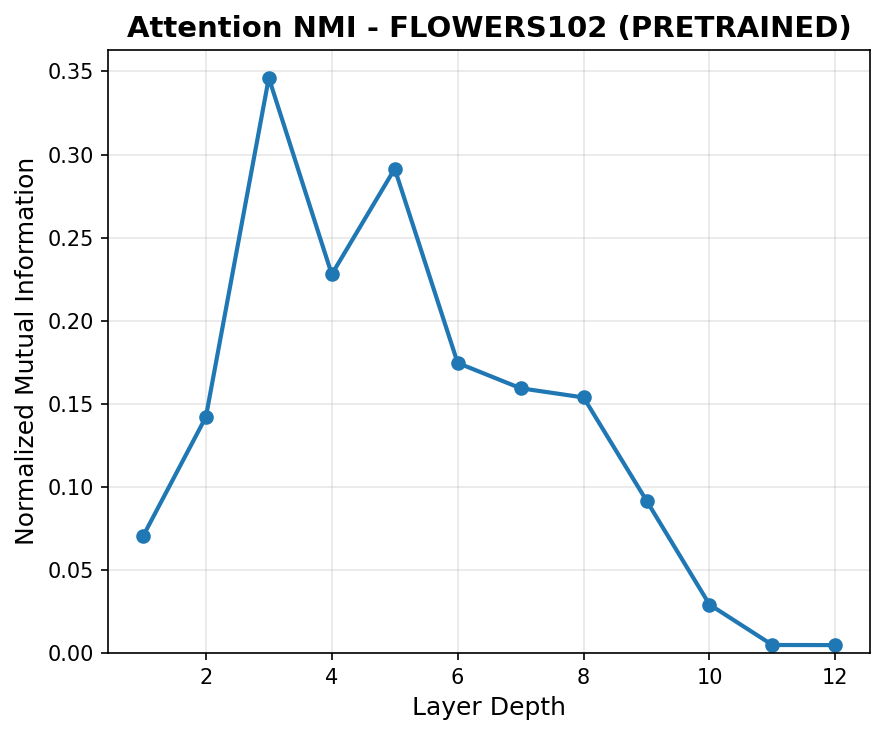

In [24]:
# Cell: Normalized Mutual Information Analysis - Updated for Fine-tuned Models
import torch.nn.functional as F 
from einops import rearrange, reduce, repeat

def calculate_nmi(attn): 
    """Normalized mutual information with return type of (batch, head)"""
    b, h, q, k = attn.shape
    pq = torch.ones([b, h, q]).to(attn.device)
    pq = F.softmax(pq, dim=-1)
    pq_ext = repeat(pq, "b h q -> b h q k", k=k)
    pk = reduce(attn * pq_ext, "b h q k -> b h k", "sum")
    pk_ext = repeat(pk, "b h k -> b h q k", q=q)
    
    mi = reduce(attn * pq_ext * torch.log(attn / pk_ext), "b h q k -> b h", "sum")
    eq = - reduce(pq * torch.log(pq), "b h q -> b h", "sum")
    ek = - reduce(pk * torch.log(pk), "b h k -> b h", "sum")
    
    nmiv = mi / torch.sqrt(eq * ek)
    return nmiv

# Run NMI analysis
if selected_model is not None:
    print(f"Running Normalized Mutual Information Analysis for {DATASET}_{METHOD}...")
    
    encoder_length = 12  # ViT-Base has 12 layers
    nmis = [AverageMeter() for _ in range(encoder_length)]
    
    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()
        
        with torch.no_grad():
            _, _, attns, _ = selected_model.forward_analysis(xs)
        
        for i, attn in enumerate(attns):
            if attn is not None:
                # Handle different attention formats
                if attn.dim() == 4:  # (batch, heads, seq, seq)
                    attn_processed = attn[:, :, 1:, 1:]  # Remove CLS token
                elif attn.dim() == 3:  # (batch, seq, seq) - single head
                    attn_processed = attn[:, 1:, 1:].unsqueeze(1)  # Add head dimension
                else:
                    continue
                
                attn_processed = attn_processed + 1e-8
                attn_processed = attn_processed / attn_processed.sum(dim=-1, keepdim=True)
                attn_processed = attn_processed.cpu().float()
                
                nmi = calculate_nmi(attn_processed)
                nmis[i].update(torch.mean(nmi, dim=0))
        
        if idx >= 5:  # Process a few batches
            break
    
    # Plot results
    fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)
    valid_nmis = []
    valid_layers = []
    
    for i, nmi in enumerate(nmis):
        if nmi.count > 0:
            valid_nmis.append(torch.mean(nmi.avg).item())
            valid_layers.append(i + 1)
    
    if valid_nmis:
        ax.plot(valid_layers, valid_nmis, marker="o", linewidth=2, markersize=6)
        ax.set_xlabel("Layer Depth", fontsize=12)
        ax.set_ylabel("Normalized Mutual Information", fontsize=12)
        ax.set_title(f"Attention NMI - {DATASET.upper()} ({METHOD.upper()})", fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(bottom=0)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid NMI data collected")
        
else:
    print("No model available for NMI analysis")

Running Comparative Attention Distance Analysis for FLOWERS102...
Analyzing attention distance for flowers102_full...
Collected distance data for 12 layers
Analyzing attention distance for flowers102_lora...
Collected distance data for 12 layers
Analyzing attention distance for flowers102_bitfit...
Collected distance data for 12 layers
Analyzing attention distance for flowers102_adaptformer...
Collected distance data for 12 layers
Analyzing attention distance for flowers102_pretrained...
Collected distance data for 12 layers

Plotting comparative attention distance results...


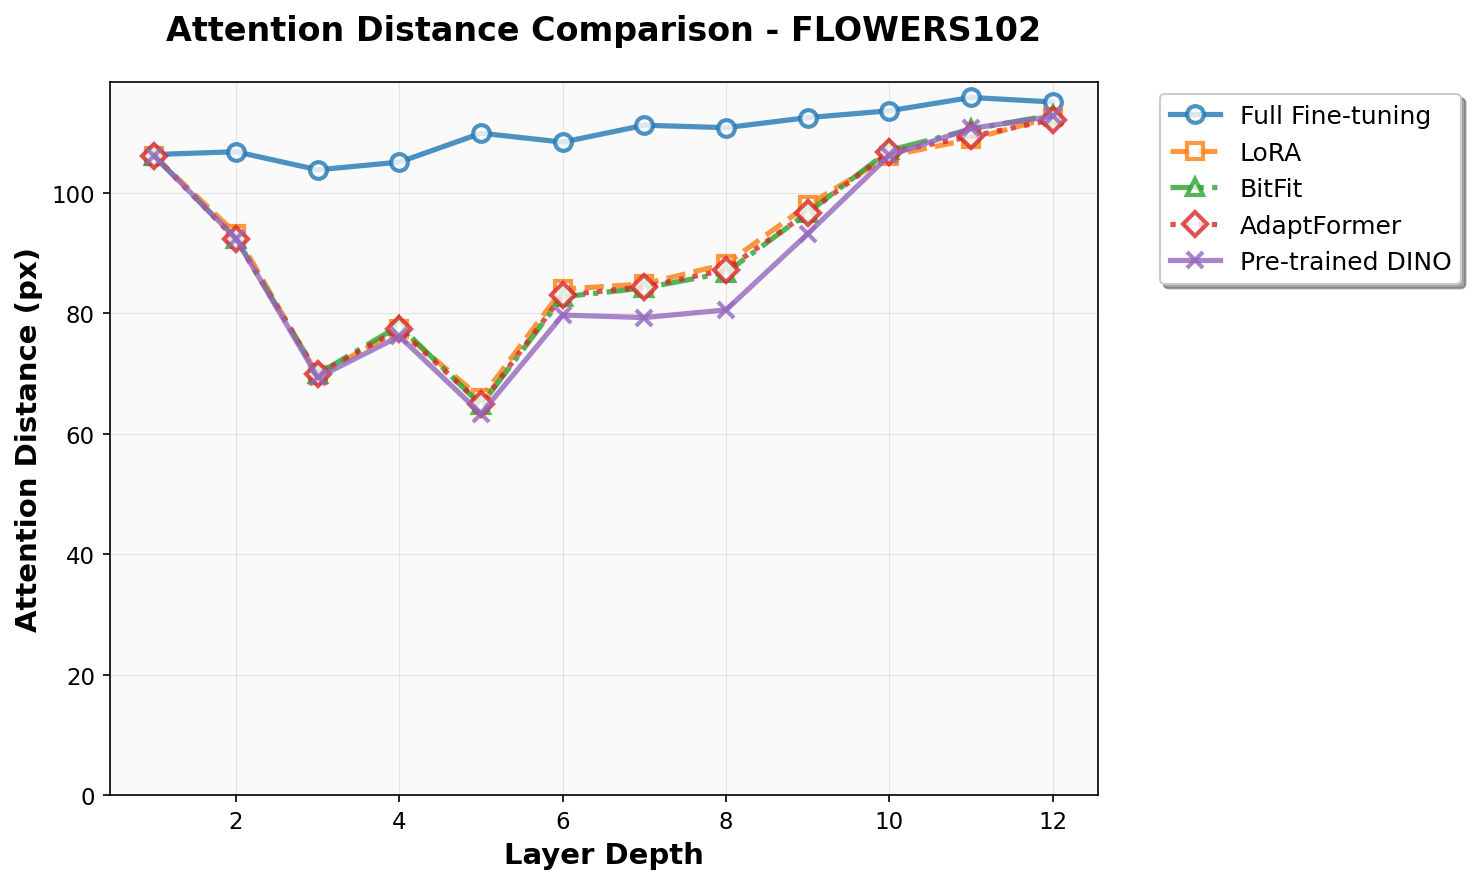


Attention Distance Summary Statistics:
Full Fine-tuning | Mean: 109.99px | Std: 3.76px | Min: 103.84px | Max: 115.86px
LoRA            | Mean: 91.26px | Std: 14.90px | Min: 65.89px | Max: 112.61px
BitFit          | Mean: 91.02px | Std: 15.33px | Min: 64.77px | Max: 112.96px
AdaptFormer     | Mean: 90.86px | Std: 15.08px | Min: 64.98px | Max: 112.18px
Pre-trained DINO | Mean: 89.16px | Std: 16.11px | Min: 63.34px | Max: 112.75px


In [ ]:
# Cell: Comparative Attention Distance Analysis - All Models
import matplotlib.pyplot as plt
import numpy as np
from timm.utils import AverageMeter

def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:
                continue
            xi, yi = (int(i/length)), (i % length)
            xj, yj = (int(j/length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])
    return distance_matrix

def calculate_mean_attention_dist(patch_size, attention_weights):
    """Calculate mean attention distance"""
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert (length**2 == num_patches), ("Num patches is not perfect square")

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape
    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1)
    mean_distances = np.mean(mean_distances, axis=-1)
    return torch.tensor(mean_distances)

def analyze_model_attention_distance(model, dataset_loader, model_name, max_batches=5):
    """Analyze attention distance for a single model"""
    print(f"Analyzing attention distance for {model_name}...")
    
    encoder_length = 12  # ViT-Base has 12 layers
    distances = [AverageMeter() for _ in range(encoder_length)]
    
    for idx, (xs, _) in enumerate(dataset_loader):
        try:
            xs = xs.cuda()
            
            with torch.no_grad():
                _, _, attns, _ = model.forward_analysis(xs)
            
            for i, attn in enumerate(attns):
                if attn is not None:
                    # Handle different attention formats
                    if attn.dim() == 4:  # (batch, heads, seq, seq)
                        attn_processed = attn[:, :, 1:, 1:]  # Remove CLS token
                    elif attn.dim() == 3:  # (batch, seq, seq) - single head
                        attn_processed = attn[:, 1:, 1:].unsqueeze(1)  # Add head dimension
                    else:
                        continue
                    
                    attn_processed = attn_processed + 1e-32
                    attn_processed = attn_processed / attn_processed.sum(dim=-1, keepdim=True)
                    attn_processed = attn_processed.cpu().float().detach().numpy()
                    
                    distance = calculate_mean_attention_dist(patch_size=16, attention_weights=attn_processed)
                    distances[i].update(torch.mean(distance, dim=0))
            
            if idx >= max_batches:
                break
                
        except Exception as e:
            print(f"Error processing batch {idx}: {e}")
            continue
    
    # Extract valid distances
    valid_distances = []
    valid_layers = []
    
    for i, distance in enumerate(distances):
        if distance.count > 0:
            valid_distances.append(torch.mean(distance.avg).item())
            valid_layers.append(i + 1)
    
    if valid_distances:
        print(f"Collected distance data for {len(valid_distances)} layers")
        return valid_layers, valid_distances
    else:
        print(f"No valid distance data collected")
        return None, None

# Run comparative attention distance analysis
if available_models and dataset_test is not None:
    print(f"Running Comparative Attention Distance Analysis for {DATASET.upper()}...")
    
    # Define visual styles for each method - FIXED: Added 'pretrained'
    method_styles = {
        'pretrained': {'marker': 'x', 'color': '#9467bd', 'linestyle': '-', 'label': 'Pre-trained DINO'},
        'full': {'marker': 'o', 'color': '#1f77b4', 'linestyle': '-', 'label': 'Full Fine-tuning'},
        'lora': {'marker': 's', 'color': '#ff7f0e', 'linestyle': '--', 'label': 'LoRA'},
        'bitfit': {'marker': '^', 'color': '#2ca02c', 'linestyle': '-.', 'label': 'BitFit'},
        'adaptformer': {'marker': 'D', 'color': '#d62728', 'linestyle': ':', 'label': 'AdaptFormer'}
    }
    
    # Collect results for all models
    results = {}
    
    for model_key, model in available_models.items():
        dataset_name, method = model_key.split('_')
        
        # Only analyze models for the current dataset
        if dataset_name == DATASET:
            layers, distances = analyze_model_attention_distance(model, dataset_test, model_key)
            if layers is not None and distances is not None:
                results[method] = (layers, distances)
    
    # Plot comparative results
    if results:
        print(f"\nPlotting comparative attention distance results...")
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
        
        for method, (layers, distances) in results.items():
            style = method_styles.get(method, {'marker': 'o', 'color': 'black', 'linestyle': '-', 'label': method})
            
            ax.plot(layers, distances, 
                   marker=style['marker'], 
                   color=style['color'],
                   linestyle=style['linestyle'],
                   linewidth=2.5, 
                   markersize=8,
                   markerfacecolor='white',
                   markeredgecolor=style['color'],
                   markeredgewidth=2,
                   label=style['label'],
                   alpha=0.8)
        
        # Customize the plot
        ax.set_xlabel("Layer Depth", fontsize=14, fontweight='bold')
        ax.set_ylabel("Attention Distance (px)", fontsize=14, fontweight='bold')
        ax.set_title(f"Attention Distance Comparison - {DATASET.upper()}", 
                    fontsize=16, fontweight='bold', pad=20)
        
        # Add grid and legend
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True, 
                 bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Set axis limits and styling
        ax.set_ylim(bottom=0)
        ax.tick_params(axis='both', which='major', labelsize=11)
        
        # Add subtle background
        ax.set_facecolor('#fafafa')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nAttention Distance Summary Statistics:")
        print("=" * 60)
        for method, (layers, distances) in results.items():
            distances_array = np.array(distances)
            print(f"{method_styles[method]['label']:15} | "
                  f"Mean: {distances_array.mean():.2f}px | "
                  f"Std: {distances_array.std():.2f}px | "
                  f"Min: {distances_array.min():.2f}px | "
                  f"Max: {distances_array.max():.2f}px")
        
    else:
        print("No valid attention distance results collected for comparison")
        
else:
    print("Cannot run comparative attention distance analysis - missing models or dataset")
    print(f"Available models: {list(available_models.keys()) if available_models else 'None'}")
    print(f"Dataset available: {dataset_test is not None}")

Running Comparative Attention NMI Analysis for FLOWERS102...
Analyzing attention NMI for flowers102_full...
Collected NMI data for 12 layers
Analyzing attention NMI for flowers102_lora...
Collected NMI data for 12 layers
Analyzing attention NMI for flowers102_bitfit...
Collected NMI data for 12 layers
Analyzing attention NMI for flowers102_adaptformer...
Collected NMI data for 12 layers
Analyzing attention NMI for flowers102_pretrained...
Collected NMI data for 12 layers

Plotting comparative attention NMI results...


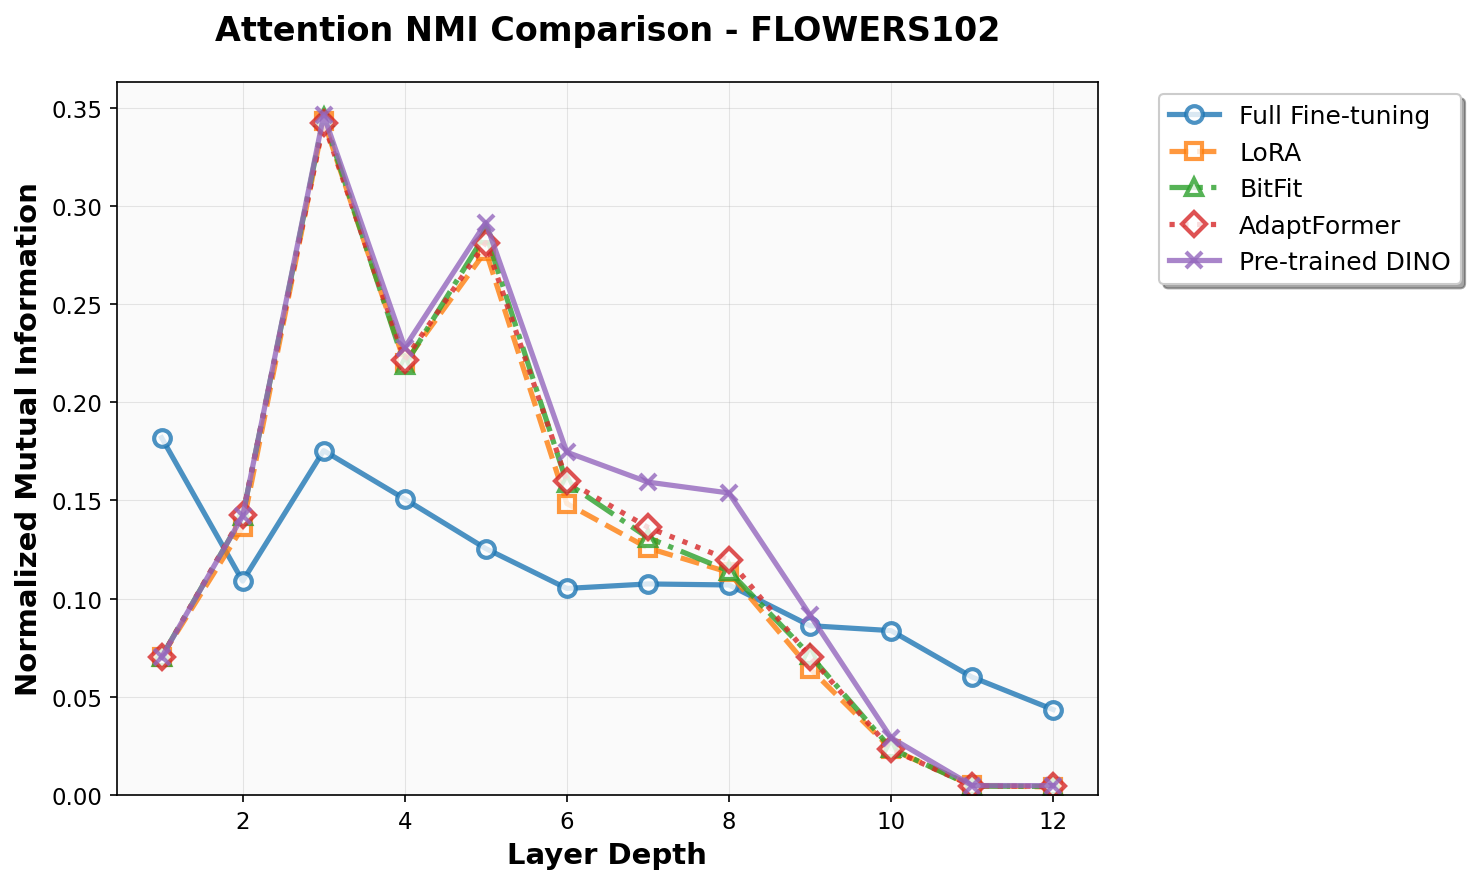


Attention NMI Summary Statistics:
Full Fine-tuning | Mean: 0.1113 | Std: 0.0403 | Min: 0.0436 | Max: 0.1820
LoRA            | Mean: 0.1277 | Std: 0.1027 | Min: 0.0041 | Max: 0.3433
BitFit          | Mean: 0.1309 | Std: 0.1039 | Min: 0.0044 | Max: 0.3450
AdaptFormer     | Mean: 0.1314 | Std: 0.1031 | Min: 0.0044 | Max: 0.3422
Pre-trained DINO | Mean: 0.1413 | Std: 0.1044 | Min: 0.0048 | Max: 0.3461


In [26]:
# Cell: Comparative Attention NMI Analysis - All Models
import matplotlib.pyplot as plt
import torch.nn.functional as F 
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter
import numpy as np

def calculate_nmi(attn): 
    """Normalized mutual information with return type of (batch, head)"""
    b, h, q, k = attn.shape
    pq = torch.ones([b, h, q]).to(attn.device)
    pq = F.softmax(pq, dim=-1)
    pq_ext = repeat(pq, "b h q -> b h q k", k=k)
    pk = reduce(attn * pq_ext, "b h q k -> b h k", "sum")
    pk_ext = repeat(pk, "b h k -> b h q k", q=q)
    
    mi = reduce(attn * pq_ext * torch.log(attn / pk_ext), "b h q k -> b h", "sum")
    eq = - reduce(pq * torch.log(pq), "b h q -> b h", "sum")
    ek = - reduce(pk * torch.log(pk), "b h k -> b h", "sum")
    
    nmiv = mi / torch.sqrt(eq * ek)
    return nmiv

def analyze_model_attention_nmi(model, dataset_loader, model_name, max_batches=5):
    """Analyze attention NMI for a single model"""
    print(f"Analyzing attention NMI for {model_name}...")
    
    encoder_length = 12  # ViT-Base has 12 layers
    nmis = [AverageMeter() for _ in range(encoder_length)]
    
    for idx, (xs, _) in enumerate(dataset_loader):
        try:
            xs = xs.cuda()
            
            with torch.no_grad():
                _, _, attns, _ = model.forward_analysis(xs)
            
            for i, attn in enumerate(attns):
                if attn is not None:
                    # Handle different attention formats
                    if attn.dim() == 4:  # (batch, heads, seq, seq)
                        attn_processed = attn[:, :, 1:, 1:]  # Remove CLS token
                    elif attn.dim() == 3:  # (batch, seq, seq) - single head
                        attn_processed = attn[:, 1:, 1:].unsqueeze(1)  # Add head dimension
                    else:
                        continue
                    
                    attn_processed = attn_processed + 1e-8
                    attn_processed = attn_processed / attn_processed.sum(dim=-1, keepdim=True)
                    attn_processed = attn_processed.cpu().float()
                    
                    nmi = calculate_nmi(attn_processed)
                    nmis[i].update(torch.mean(nmi, dim=0))
            
            if idx >= max_batches:
                break
                
        except Exception as e:
            print(f"Error processing batch {idx}: {e}")
            continue
    
    # Extract valid NMI values
    valid_nmis = []
    valid_layers = []
    
    for i, nmi in enumerate(nmis):
        if nmi.count > 0:
            valid_nmis.append(torch.mean(nmi.avg).item())
            valid_layers.append(i + 1)
    
    if valid_nmis:
        print(f"Collected NMI data for {len(valid_nmis)} layers")
        return valid_layers, valid_nmis
    else:
        print(f"No valid NMI data collected")
        return None, None

# Run comparative attention NMI analysis
if available_models and dataset_test is not None:
    print(f"Running Comparative Attention NMI Analysis for {DATASET.upper()}...")
    
    # Define visual styles for each method (same as previous)
    method_styles = {
        'pretrained': {'marker': 'x', 'color': '#9467bd', 'linestyle': '-', 'label': 'Pre-trained DINO'},
        'full': {'marker': 'o', 'color': '#1f77b4', 'linestyle': '-', 'label': 'Full Fine-tuning'},
        'lora': {'marker': 's', 'color': '#ff7f0e', 'linestyle': '--', 'label': 'LoRA'},
        'bitfit': {'marker': '^', 'color': '#2ca02c', 'linestyle': '-.', 'label': 'BitFit'},
        'adaptformer': {'marker': 'D', 'color': '#d62728', 'linestyle': ':', 'label': 'AdaptFormer'}
    }
    
    # Collect results for all models
    results = {}
    
    for model_key, model in available_models.items():
        dataset_name, method = model_key.split('_')
        
        # Only analyze models for the current dataset
        if dataset_name == DATASET:
            layers, nmis = analyze_model_attention_nmi(model, dataset_test, model_key)
            if layers is not None and nmis is not None:
                results[method] = (layers, nmis)
    
    # Plot comparative results
    if results:
        print(f"\nPlotting comparative attention NMI results...")
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
        
        for method, (layers, nmis) in results.items():
            style = method_styles.get(method, {'marker': 'o', 'color': 'black', 'linestyle': '-', 'label': method})
            
            ax.plot(layers, nmis, 
                   marker=style['marker'], 
                   color=style['color'],
                   linestyle=style['linestyle'],
                   linewidth=2.5, 
                   markersize=8,
                   markerfacecolor='white',
                   markeredgecolor=style['color'],
                   markeredgewidth=2,
                   label=style['label'],
                   alpha=0.8)
        
        # Customize the plot
        ax.set_xlabel("Layer Depth", fontsize=14, fontweight='bold')
        ax.set_ylabel("Normalized Mutual Information", fontsize=14, fontweight='bold')
        ax.set_title(f"Attention NMI Comparison - {DATASET.upper()}", 
                    fontsize=16, fontweight='bold', pad=20)
        
        # Add grid and legend
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True, 
                 bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Set axis limits and styling
        ax.set_ylim(bottom=0)
        ax.tick_params(axis='both', which='major', labelsize=11)
        
        # Add subtle background
        ax.set_facecolor('#fafafa')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nAttention NMI Summary Statistics:")
        print("=" * 60)
        for method, (layers, nmis) in results.items():
            nmis_array = np.array(nmis)
            print(f"{method_styles[method]['label']:15} | "
                  f"Mean: {nmis_array.mean():.4f} | "
                  f"Std: {nmis_array.std():.4f} | "
                  f"Min: {nmis_array.min():.4f} | "
                  f"Max: {nmis_array.max():.4f}")
        
    else:
        print("No valid attention NMI results collected for comparison")
        
else:
    print("Cannot run comparative attention NMI analysis - missing models or dataset")
    print(f"Available models: {list(available_models.keys()) if available_models else 'None'}")
    print(f"Dataset available: {dataset_test is not None}")